# STEP 1: Importing Libraries

In [2]:
!pip install utils

In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utils
import os
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
#from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.1


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# STEP 2: Preparing the Data

Data Source : https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

In [10]:
#set the path to the main dir
main_dir="C:\\Users\\krish\\OneDrive\\Desktop\\Study\\CV\\Facial Expression Recognizer\\Facial_expressions_data"
#set the path to the train dir
train_dir=os.path.join(main_dir,'train')
#set the path to the test dir
test_dir=os.path.join(main_dir,'test')

In [11]:
#directory with the training Expressions
train_anger_dir=os.path.join(train_dir,'Angry')
train_angry_expressions=os.listdir(train_anger_dir)

train_disgust_dir=os.path.join(train_dir,'Disgust')
train_disgust_expressions=os.listdir(train_disgust_dir)

train_fear_dir=os.path.join(train_dir,'Fear')
train_fear_expressions=os.listdir(train_fear_dir)

train_happy_dir=os.path.join(train_dir,'Happy')
train_happy_expressions=os.listdir(train_happy_dir)

train_sad_dir=os.path.join(train_dir,'Sad')
train_sad_expressions=os.listdir(train_sad_dir)

train_surprise_dir=os.path.join(train_dir,'Surprise')
train_surprise_expressions=os.listdir(train_surprise_dir)

train_neutral_dir=os.path.join(train_dir,'Neutral')
train_neutral_expressions=os.listdir(train_neutral_dir)

# STEP 3: Visualising Expressions

In [15]:
'C:\\Users\\krish\\OneDrive\\Desktop\\Study\\CV\\Facial Expression Recognizer\\Facial_expressions_data\\train\\Angry\\0.jpg'.split('\\')[-1]

'0.jpg'

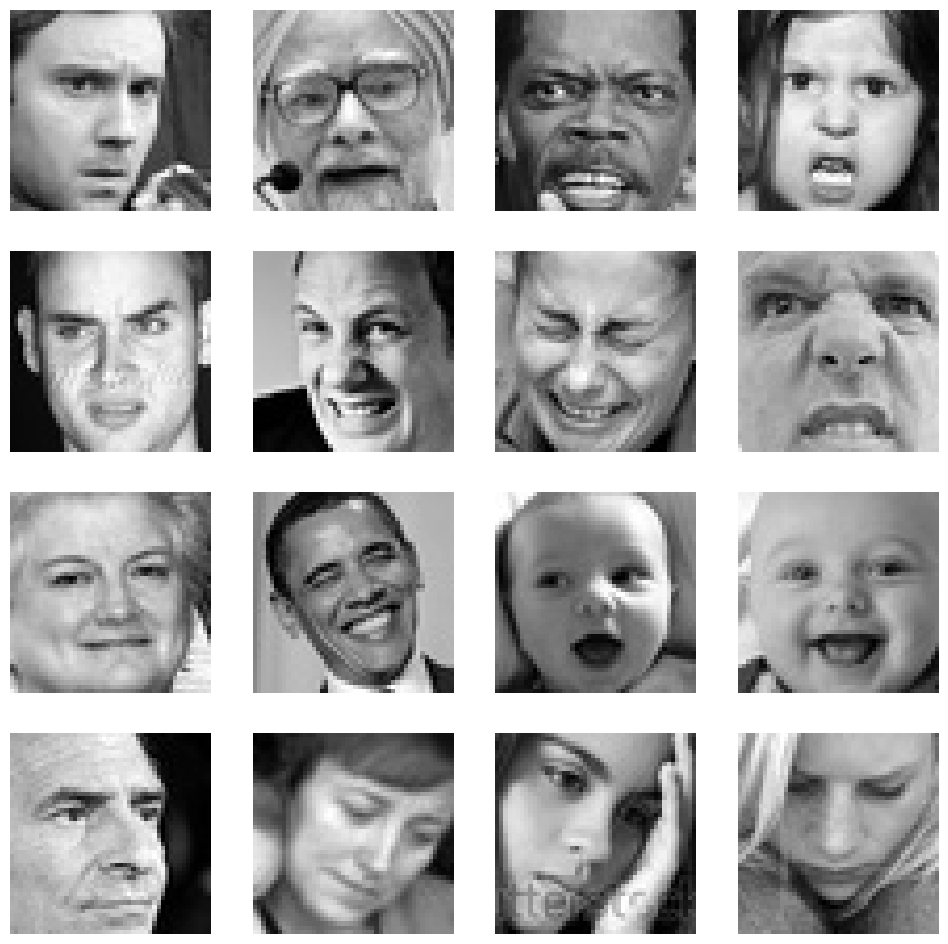

<Figure size 640x480 with 0 Axes>

In [17]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
#set the number of columns and rows
rows=4
cols=4
#set the figure size
plt.figure(figsize=(12,12))
#get the filenames from the covid & normal dir of the train dataset
angry_pic=[os.path.join(train_anger_dir,filename) for filename in train_angry_expressions[0:4]]
disgusted_pic=[os.path.join(train_disgust_dir,filename) for filename in train_disgust_expressions[4:8]]
happy_pic=[os.path.join(train_happy_dir,filename) for filename in train_happy_expressions[0:4]]
sad_pic=[os.path.join(train_sad_dir,filename) for filename in train_sad_expressions[0:4]]

#print the list
# print(angry_pic)
# print(disgusted_pic)

merged_list=angry_pic+disgusted_pic+happy_pic+sad_pic
for i , img_path in enumerate(merged_list):
    data=img_path.split('\\')[-1]
    sp=plt.subplot(rows,cols,i+1)
    sp.axis('off')
    img=mpimg.imread(img_path)
    #sp.set_title(data, fontsize=10)
    plt.imshow(img, cmap='gray')

plt.show()
plt.tight_layout()


# STEP 4: Creating Train/Val/Test Batches

In [18]:
# generate training,testing and validation batches 
dgen_train=ImageDataGenerator(rescale=1/255,
                              validation_split=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)

dgen_validation=ImageDataGenerator(rescale=1/255)
dgen_test=ImageDataGenerator(rescale=1/255)


In [19]:
train_generator=dgen_train.flow_from_directory(train_dir,
                                               target_size=(50,50),
                                               subset='training',
                                               color_mode='grayscale',
                                               batch_size=32,
                                               
                                               shuffle=True,
                                               class_mode='categorical')  

validation_generator=dgen_train.flow_from_directory(train_dir,
                                               target_size=(50,50),
                                               subset='validation',
                                               batch_size=32,
                                               color_mode='grayscale',
                                               class_mode='categorical')
test_generator=dgen_test.flow_from_directory(test_dir,
                                               target_size=(50,50),
                                               batch_size=32,
                                               color_mode='grayscale',
                                               class_mode='categorical')

Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.
Found 7625 images belonging to 7 classes.


In [20]:
#get the class indices
train_generator.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [21]:
#get the image shape
train_generator.image_shape

(50, 50, 1)

# STEP 5: Creating CNN Model

In [24]:
def createModel(image_shape):
    model=Sequential()
    # First Conv Layer
    model.add(Conv2D(filters=64,kernel_size=(3,3)
                    ,padding='same',activation='relu',input_shape=image_shape))
    model.add(BatchNormalization())
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    # Second Conv Layer
    model.add(Conv2D(filters=128,kernel_size=(5,5),padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    # Third Conv Layer
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    # Fourth Conv Layer
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
    model.add(BatchNormalization())
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    # First Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
#     model.add(Activation='relu')
    model.add(Dropout(0.25))
    # Second Fully Connected Layer
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
#     model.add(Activation='relu')
    model.add(Dropout(0.25))
    # Output Layer
    model.add(Dense(7,activation='softmax'))
    
    return model

In [25]:
model=createModel(train_generator.image_shape)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        640       
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       204928    
                                                                 
 batch_normalization_6 (Batc  (None, 25, 25, 128)     

# STEP 6: Compile & Train the model

In [27]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001)
             ,loss='categorical_crossentropy'
             ,metrics='accuracy')

In [28]:
epochs=25
steps_per_epoch=train_generator.n/train_generator.batch_size
validation_steps=validation_generator.n/validation_generator.batch_size

checkpoint= ModelCheckpoint("model_weights.h5",monitor='val_accuracy', mode=max, save_weights_only=True, verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001)

callbacks=[checkpoint, reduce_lr,]

In [29]:
%time
#train the model
history=model.fit(train_generator, epochs=epochs, 
                  validation_data=validation_generator,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/25
721/720 [==============================] - ETA: 0s - loss: 2.0502 - accuracy: 0.2199
Epoch 1: saving model to model_weights.h5
720/720 [==============================] - 156s 203ms/step - loss: 2.0502 - accuracy: 0.2199 - val_loss: 2.0528 - val_accuracy: 0.2515 - lr: 0.0010
Epoch 2/25
720/720 [============================>.] - ETA: 0s - loss: 1.7738 - accuracy: 0.3022
Epoch 2: saving model to model_weights.h5
720/720 [==============================] - 28s 39ms/step - loss: 1.7741 - accuracy: 0.3020 - val_loss: 2.2122 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 3/25
721/720 [==============================] - ETA: 0s - loss: 1.6265 - accuracy: 0.3654
Epoch 3: saving model to model_weights.h5
720/720 [==============================] - 28s 39ms/step - loss: 1.6265 - accuracy: 0.3654 - val_loss: 1.6036 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 4/25
720/720 [============================>.] - ETA: 0s - loss: 1.5545 - accuracy: 0.3992
Epoch 4: sa

# STEP 7 : Performance Evaluation

In [30]:
#get the keys of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

Text(0.5, 1.0, 'Training & Validation Losses')

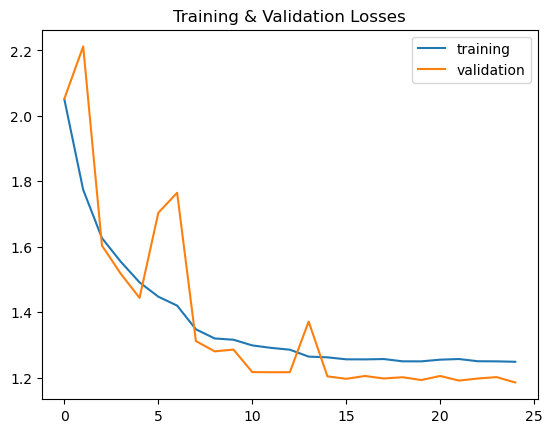

In [31]:
#plot graph between training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title("Training & Validation Losses")

Text(0.5, 1.0, 'Training & Validation Accuracy')

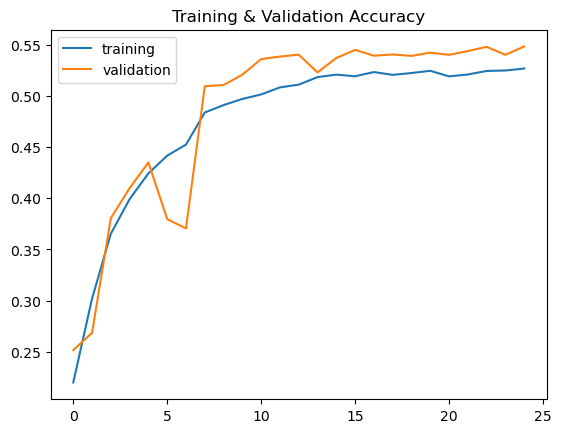

In [32]:
#plot graph between training and validation accuarcy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title("Training & Validation Accuracy")

In [33]:
# get the test acuarcy and loss
model.evaluate(test_generator, verbose=2)

239/239 - 39s - loss: 1.1596 - accuracy: 0.5622 - 39s/epoch - 162ms/step


[1.15957510471344, 0.5622295141220093]

# STEP 8: Saving the model as JSON 

In [34]:
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)